In this notebook a **simple** NDVI time series approach is explored to predict the NDVI in a single region of Senegal.
- Model: SARIMA(X)
- Data: The data was downloaded and processed by Ondrej from ASAP, and is located in the google drive.
    - The dataset contains 10-day information (unlike what we have from GEE and IPAR). The goal is to see the feasability with a ready-to-go dataset that scans many years. 
    - Data: https://drive.google.com/drive/folders/1hRS1mx2YES-nbCCn9OFmciSQhorHeAds?usp=sharing
    - Notebook: https://github.com/OmdenaAI/GPSDD-Food-Security-Senegal/blob/main/notebooks/task_1_climate-risk/ASAP_data_1.ipynb

- Since these are simple models, focus is on a single region (Kaffrine) as a feasability study
- Frist some properties of the time series are looked at
- Then the model is 'trained' on 2002-2013 + 2014 data (including) up to June, with the aim to predict the NDVI for the rest of the critical growing season (July, August, September) within the current year
- There are 2 different models: SARIMA and SARIMAX
  - Prediction of NDVI based on solely past NDVI data (SARIMA). Optimized scanning large set of variables. 
  - Prediction of NDVI based on past NDVI data and rainfall as the exogenous term (SARIMAX). Optimized using subset of variables based on the above. The idea was to see if adding rainfall information at the time of fitting (past) and during the forecast (we always have rainfall forecast) would improve the model. 
- The models are saved and are studied in time_series_simple_forecast_performance notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import datetime as dt

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from itertools import product

import warnings
#warnings.filterwarnings('ignore')

%matplotlib inline

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

# Metrics from sklearn
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

#from tqdm import tqdm_notebook
#from itertools import product
#import warnings
#warnings.filterwarnings('ignore')

In [2]:
asap_file_path = '../../data/external/SEN_asap_region.csv'

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true))*100

In [3]:
asap_file = pd.read_csv(asap_file_path, parse_dates=['date'])
asap_file.head(10)

,Unnamed: 0,region_name,variable_name,sensor_name,class_name,date,value,year,month,day,yearday
0,0,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-01-01,25.302,1989,1,1,1
1,1,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-01-11,26.047,1989,1,11,11
2,2,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-05-01,31.429,1989,5,1,121
3,3,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-05-11,32.047,1989,5,11,131
4,4,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-05-21,32.364,1989,5,21,141
5,5,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-06-01,31.287,1989,6,1,152
6,6,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-06-11,28.216,1989,6,11,162
7,7,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-06-21,27.000,1989,6,21,172
8,8,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-07-01,26.000,1989,7,1,182
9,9,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-07-11,26.000,1989,7,11,192


In [4]:
classes = asap_file["class_name"].unique()
regions = asap_file["region_name"].unique()
variables = asap_file["variable_name"].unique()
print(classes)
print(variables)
print(regions)

['Rangeland during growing cycle' 'Crop during growing cycle' 'Rangeland'
 'Crop']
['Temperature' 'NDVI Cumulated - zscore' 'SPI - 3 months'
 'Water Satisfaction Index (WSI)' 'NDVI - zscore' 'NDVI' 'Rainfall']
['Kolda' 'Fatick' 'Dakar' 'Kedougou' 'Tambacounda' 'Sedhiou' 'Kaffrine'
 'Kaolack' 'Thies' 'Ziguinchor' 'Diourbel' 'Saint louis' 'Louga' 'Matam']


In [5]:
def are_dates_unique(df):
    if(len(df["date"].unique())== df.shape[0]):
        return True
    else:
        return False
    
def date_as_index(df):
    if are_dates_unique(df):
        df = df.set_index('date')
        df.sort_index(inplace=True)
        return df
    else:
        warnings.warn('Dates are not unique, could not set them as indices')
        return df
    
# For now keeping some additional info as class_name, region_name etc although they will be specific
def region_class_value_specific_df(df, cl, region, wanted_columns = ["class_name","region_name", "variable_name", "date", "value"]):
    selected_subset_df = df.loc[(df["class_name"] == cl) &  (df["region_name"] == region), wanted_columns]
    df_ndvi = selected_subset_df.loc[(df["variable_name"] == "NDVI")]
    df_temperature = selected_subset_df.loc[(df["variable_name"] == "Temperature")]
    df_rainfall = selected_subset_df.loc[(df["variable_name"] == "Rainfall")]
    # use dates as indices (if they are unique)
    df_ndvi = date_as_index(df_ndvi)
    df_temperature = date_as_index(df_temperature)
    df_rainfall = date_as_index(df_rainfall)
    
    earliest_date_ndvi = min(df_ndvi.index)
    earliest_date_temperature = min(df_temperature.index)
    earliest_date_rainfall = min(df_rainfall.index)
    earliest_date = max([earliest_date_ndvi, earliest_date_temperature, earliest_date_rainfall])
    print("Earliest date: {}".format(earliest_date))

    last_date_ndvi = max(df_ndvi.index)
    last_date_temperature = max(df_temperature.index)
    last_date_rainfall = max(df_rainfall.index)
    last_date = min([last_date_ndvi, last_date_temperature, last_date_rainfall])
    print("Latest date: {}".format(last_date))
    return df_ndvi, df_temperature, df_rainfall

In [6]:
# Later can loop through the lists of classes, regions, variables, for now keep it simple 
crop_Kaffrine_ndvi, crop_Kaffrine_temperature, crop_Kaffrine_rainfall = region_class_value_specific_df(df = asap_file, cl = "Crop", region = "Kaffrine")
#print(crop_Kaffrine_ndvi.describe(include='all'))
#print(crop_Kaffrine_temperature.describe(include='all'))
#print(crop_Kaffrine_rainfall.describe(include='all'))
print(crop_Kaffrine_ndvi.head(3))
print(crop_Kaffrine_temperature.head(3))
print(crop_Kaffrine_rainfall.head(3))

Earliest date: 2001-10-01 00:00:00
Latest date: 2020-11-21 00:00:00
           class_name region_name variable_name  value
date                                                  
2001-10-01       Crop    Kaffrine          NDVI  0.566
2001-10-11       Crop    Kaffrine          NDVI  0.510
2001-10-21       Crop    Kaffrine          NDVI  0.442
           class_name region_name variable_name   value
date                                                   
1989-01-01       Crop    Kaffrine   Temperature  23.092
1989-01-11       Crop    Kaffrine   Temperature  24.142
1989-01-21       Crop    Kaffrine   Temperature  25.853
           class_name region_name variable_name  value
date                                                  
1989-01-01       Crop    Kaffrine      Rainfall  0.000
1989-01-11       Crop    Kaffrine      Rainfall  0.000
1989-01-21       Crop    Kaffrine      Rainfall  0.085


In [7]:
# Split into training, validation, test by year
# Training: 2002-2013
# With 10 day intervals, this will mean making 36 new predictions (for whole year, next year)
# Validation: 2014 # For now, want to keep 2014 here to have the chance to use/test with the IPAR data, maybe
# Test: 2015
def split_training_validation_test_by_year(df, min_training='2002', max_training='2013', validation='2014', test='2015'):
    training_data = df.loc[min_training:max_training]
    validation_data = df.loc[validation]
    test_data = df.loc[test]
    return training_data,validation_data, test_data

# Another option: Few weeks after the planting, predict the NDVI during the growing/critical season... 
# Data given up to june, predict july? 
# Here need to know about the planting, growing seasons and is dependent on the crop, maybe nicer with DNN 
def split_training_validation_test_by_date(df, min_training='2002-01', max_training='2014-06', min_validation='2014-07', max_validation='2014-09'):
    training_data = df.loc[min_training:max_training]
    validation_data = df.loc[min_validation:max_validation]
    return training_data, validation_data
    

In [8]:
train_crop_ndvi, val_crop_ndvi = split_training_validation_test_by_date(crop_Kaffrine_ndvi)
train_crop_rainfall, val_crop_rainfall = split_training_validation_test_by_date(crop_Kaffrine_rainfall)

# Start plotting the training. First focus: ndvi and rainfall

In [9]:
print(train_crop_ndvi)
print(val_crop_ndvi)

           class_name region_name variable_name  value
date                                                  
2002-01-01       Crop    Kaffrine          NDVI  0.252
2002-01-11       Crop    Kaffrine          NDVI  0.237
2002-01-21       Crop    Kaffrine          NDVI  0.221
2002-02-01       Crop    Kaffrine          NDVI  0.211
2002-02-11       Crop    Kaffrine          NDVI  0.203
...               ...         ...           ...    ...
2014-05-11       Crop    Kaffrine          NDVI  0.212
2014-05-21       Crop    Kaffrine          NDVI  0.204
2014-06-01       Crop    Kaffrine          NDVI  0.198
2014-06-11       Crop    Kaffrine          NDVI  0.194
2014-06-21       Crop    Kaffrine          NDVI  0.195

[450 rows x 4 columns]
           class_name region_name variable_name  value
date                                                  
2014-07-01       Crop    Kaffrine          NDVI  0.203
2014-07-11       Crop    Kaffrine          NDVI  0.222
2014-07-21       Crop    Kaffrine        

In [10]:
def plot_moving_average(series, window, plot_intervals = False, scale = 1.96):
    rolling_mean = series.rolling(window=window).mean()
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label = 'Rolling mean trend')
    
    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label = 'Upper bound and Lower bound')
        plt.plot(lower_bound, 'r--')
    
    plt.plot(series[window:],label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)    

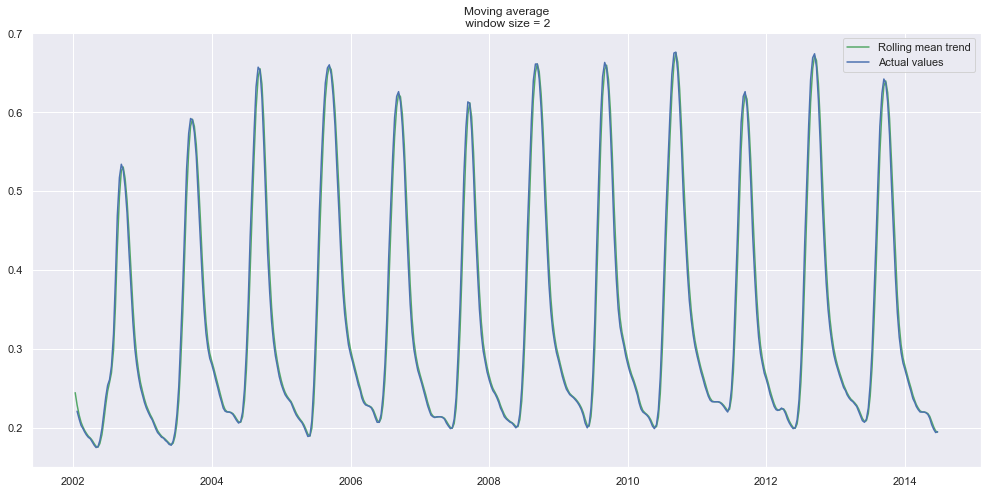

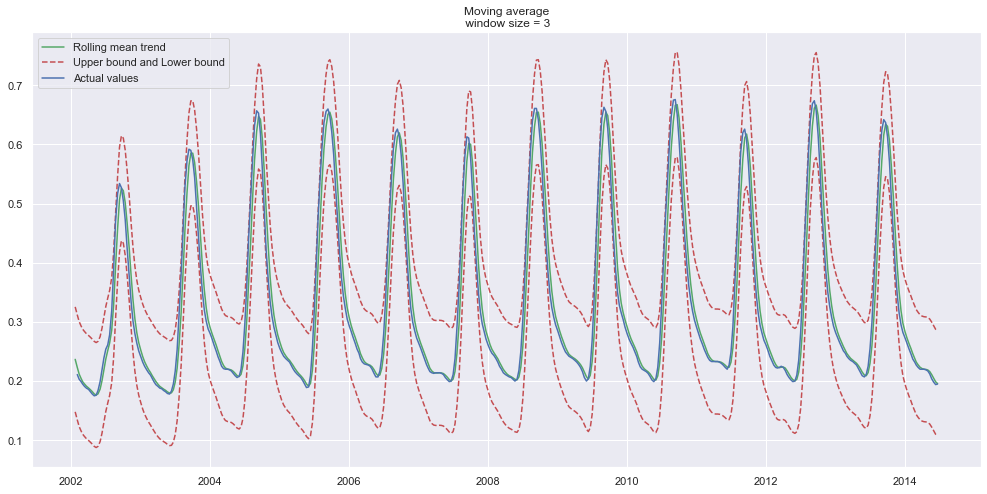

In [11]:
plot_moving_average(train_crop_ndvi.value, 2)

# Smooth by the previous 3 instances (month)
plot_moving_average(train_crop_ndvi.value, 3, plot_intervals=True)

#Smooth by the previous 9 instances (3 months)
#plot_moving_average(train_crop_ndvi.value, 9)

#Smooth by 36 instances (~year)
#plot_moving_average(train_crop_ndvi.value, 36, plot_intervals=True)

Seems very stationary to me but...
Do the Dickey Fuller Test

In [12]:
def tsplot(y, lags_chosen=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    # to use the style only for this block without changing the global styling    
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout,(1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        # adfuller doc: https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f})'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags_chosen,ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags_chosen, ax=pacf_ax, method='ywm')
        plt.tight_layout()

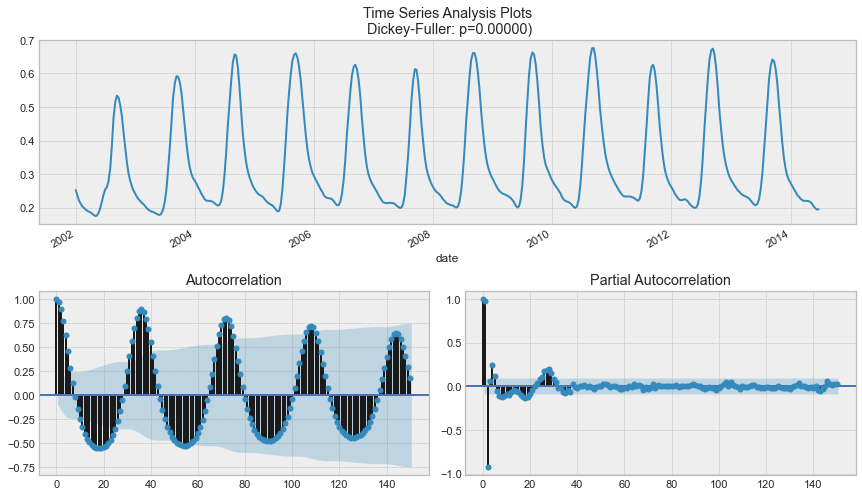

In [13]:
tsplot(train_crop_ndvi.value, lags_chosen = 150)

In [14]:
# For auto arima 
import pmdarima as pm

# For serialization:
import joblib
import pickle

In [16]:
# Seasonal - fit stepwise auto-ARIMA
# m is for the seasonal trends, 12 for monthly data, m = 1 for daily etc
smodel = pm.auto_arima(train_crop_ndvi.value, test='adf',
                       seasonal=True, m=36,
                       start_p=0, start_q=0,
                       max_p=5, max_q=5,
                       start_P=0, start_Q=0,
                       max_P=5, max_Q=5,
                       trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True, information_criterion='aic')

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[36] intercept   : AIC=-453.230, Time=0.30 sec
 ARIMA(1,0,0)(1,0,0)[36] intercept   : AIC=inf, Time=6.14 sec
 ARIMA(0,0,1)(0,0,1)[36] intercept   : AIC=inf, Time=7.79 sec
 ARIMA(0,0,0)(0,0,0)[36]             : AIC=366.687, Time=0.08 sec
 ARIMA(0,0,0)(1,0,0)[36] intercept   : AIC=inf, Time=4.32 sec
 ARIMA(0,0,0)(0,0,1)[36] intercept   : AIC=inf, Time=5.49 sec
 ARIMA(0,0,0)(1,0,1)[36] intercept   : AIC=-1601.604, Time=9.06 sec
 ARIMA(0,0,0)(2,0,1)[36] intercept   : AIC=-1567.464, Time=43.54 sec
 ARIMA(0,0,0)(1,0,2)[36] intercept   : AIC=inf, Time=52.46 sec
 ARIMA(0,0,0)(0,0,2)[36] intercept   : AIC=inf, Time=37.93 sec
 ARIMA(0,0,0)(2,0,0)[36] intercept   : AIC=inf, Time=38.45 sec
 ARIMA(0,0,0)(2,0,2)[36] intercept   : AIC=inf, Time=134.85 sec
 ARIMA(1,0,0)(1,0,1)[36] intercept   : AIC=-2782.819, Time=10.74 sec
 ARIMA(1,0,0)(0,0,1)[36] intercept   : AIC=inf, Time=5.84 sec
 ARIMA(1,0,0)(2,0,1)[36] intercept   : AIC=-2716.610, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  450
Model:             SARIMAX(3, 0, 1)x(3, 0, 1, 36)   Log Likelihood                1909.843
Date:                            Fri, 15 Jan 2021   AIC                          -3799.686
Time:                                    17:10:09   BIC                          -3758.593
Sample:                                         0   HQIC                         -3783.489
                                            - 450                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      0.486      0.627      -0.001       0.001
ar.L1          2.4067      0.037     64.209      0.000       2.333       2.480
ar.L2         -2.0710      0.071    -29.016      0.000      -2.211      -1.931
ar.L3          0.6581      0.037     17.782      0.000       0.586       0.731
ma.L1          0.2737      0.057      4.835      0.000       0.163       0.385
ar.S.L36      -0.1169      0.298     -0.392      0.695      -0.701       0.468
ar.S.L72       0.6608      0.151      4.378      0.000       0.365       0.957
ar.S.L108      0.3506      0.132      2.654      0.008       0.092       0.610
ma.S.L36       0.5601      0.310      1.806      0.071      -0.048       1.168
sigma2      1.008e-05    5.7e-07     17.698      0.000    8.96e-06    1.12e-05
===================================================================================
Ljung-Box (Q):                       68.07   Jarque-Bera (JB):               100.08
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
with open('smodel_sarima_kaffrine_next_weeks.pkl', 'wb') as pkl:
    pickle.dump(smodel, pkl)    

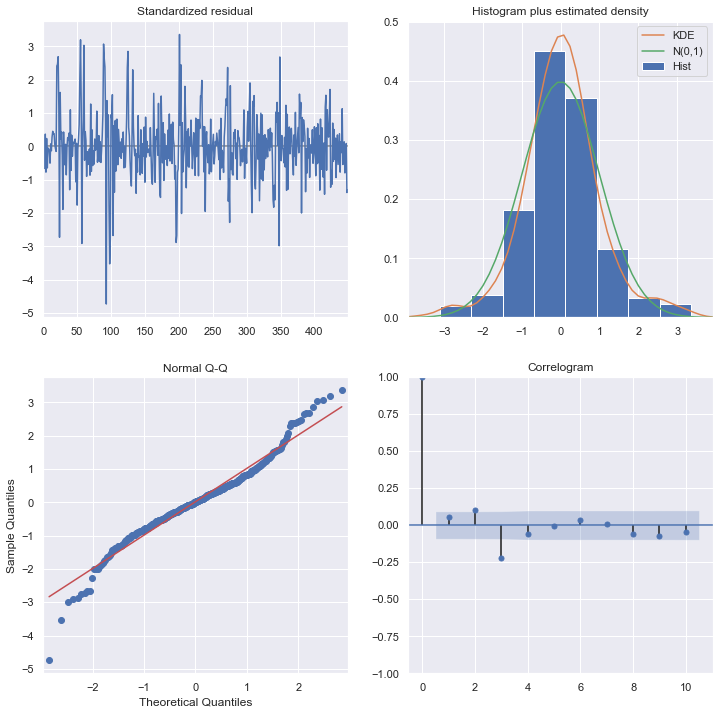

In [18]:
# The p values don't look great... Let's see

smodel.plot_diagnostics(figsize=(12,12))
plt.show()


In [20]:
# Time series with rainfall as the exogenous term
smodel_arima_predictions = smodel.predict(n_periods=val_crop_ndvi.shape[0])  
print(smodel_arima_predictions)
print(val_crop_ndvi.value)

[0.21138322 0.2478263  0.31187394 0.38405079 0.45666783 0.52299994
 0.56246853 0.57875431 0.57220559]
date
2014-07-01    0.203
2014-07-11    0.222
2014-07-21    0.264
2014-08-01    0.324
2014-08-11    0.401
2014-08-21    0.487
2014-09-01    0.553
2014-09-11    0.591
2014-09-21    0.593
Name: value, dtype: float64


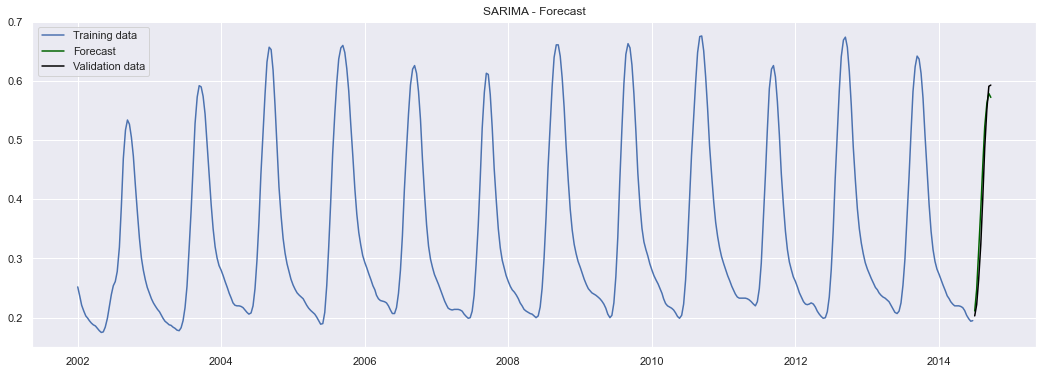

In [21]:
index_of_predictions = val_crop_ndvi.index
smodel_arima_predictions_series = pd.Series(smodel_arima_predictions, index=index_of_predictions)

# First visualise and compare in plots
fig = plt.figure(figsize=(18,6))
plt.plot(train_crop_ndvi.value, label = 'Training data')
plt.plot(smodel_arima_predictions_series, color='darkgreen', label = 'Forecast')
plt.plot(val_crop_ndvi.value, color = 'black', label = 'Validation data')
plt.legend(loc='best')
plt.grid('True')
plt.title("SARIMA - Forecast")
plt.show()

In [22]:
# Now look at some common metrics, although these might be misleading because we mainly care about the NDVI during growth
m_absolute_percentage_error = mean_absolute_percentage_error(val_crop_ndvi.value, smodel_arima_predictions_series)
print(m_absolute_percentage_error)

mae = mean_absolute_error(val_crop_ndvi.value, smodel_arima_predictions_series)
print(mae)

8.99963572234658
0.030701184015135417


In [23]:
# Merge the NDVI and rainfall in the same dataframe (not necessary in this case since they originated from the same dataset)

# Just looking at the data in a primitive way :) 
print(train_crop_ndvi.describe(include='all'))
print(train_crop_rainfall.describe(include='all'))

print(train_crop_ndvi)
print(train_crop_rainfall)

       class_name region_name variable_name       value
count         450         450           450  450.000000
unique          1           1             1         NaN
top          Crop    Kaffrine          NDVI         NaN
freq          450         450           450         NaN
mean          NaN         NaN           NaN    0.332376
std           NaN         NaN           NaN    0.145750
min           NaN         NaN           NaN    0.175000
25%           NaN         NaN           NaN    0.221000
50%           NaN         NaN           NaN    0.264000
75%           NaN         NaN           NaN    0.430750
max           NaN         NaN           NaN    0.676000
       class_name region_name variable_name       value
count         450         450           450  450.000000
unique          1           1             1         NaN
top          Crop    Kaffrine      Rainfall         NaN
freq          450         450           450         NaN
mean          NaN         NaN           NaN   15

In [24]:
# Now, fit a model with an exogenous term (rainfall)
# Use what we learnt from the above fit model (such as the d, D values which take a lot of time...) to reduce run time
smodel_x = pm.auto_arima(train_crop_ndvi[['value']], exogenous=train_crop_rainfall[['value']], test='adf',
                       seasonal=True, m=36,
                       start_p=0, start_q=0,
                       max_p=5, max_q=5,
                       start_P=0, start_Q=0,
                       max_P=5, max_Q=5, d=0, trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True, information_criterion='aic')

smodel_x.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[36] intercept   : AIC=-705.202, Time=0.32 sec
 ARIMA(1,0,0)(1,0,0)[36] intercept   : AIC=inf, Time=15.15 sec
 ARIMA(0,0,1)(0,0,1)[36] intercept   : AIC=inf, Time=9.92 sec
 ARIMA(0,0,0)(0,0,0)[36]             : AIC=50.813, Time=0.26 sec
 ARIMA(0,0,0)(1,0,0)[36] intercept   : AIC=inf, Time=7.56 sec
 ARIMA(0,0,0)(0,0,1)[36] intercept   : AIC=-954.839, Time=6.05 sec
 ARIMA(0,0,0)(1,0,1)[36] intercept   : AIC=-1615.661, Time=14.88 sec
 ARIMA(0,0,0)(2,0,1)[36] intercept   : AIC=-1606.763, Time=61.54 sec
 ARIMA(0,0,0)(1,0,2)[36] intercept   : AIC=-1547.561, Time=60.36 sec
 ARIMA(0,0,0)(0,0,2)[36] intercept   : AIC=inf, Time=37.70 sec
 ARIMA(0,0,0)(2,0,0)[36] intercept   : AIC=inf, Time=29.13 sec
 ARIMA(0,0,0)(2,0,2)[36] intercept   : AIC=-1609.544, Time=56.29 sec
 ARIMA(1,0,0)(1,0,1)[36] intercept   : AIC=inf, Time=9.66 sec
 ARIMA(0,0,1)(1,0,1)[36] intercept   : AIC=-1998.565, Time=17.86 sec
 ARIMA(0,0,1)(1,0,0)[36] intercept   :

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  450
Model:             SARIMAX(1, 0, 5)x(2, 0, [1], 36)   Log Likelihood                1948.782
Date:                              Fri, 15 Jan 2021   AIC                          -3873.564
Time:                                      21:19:20   BIC                          -3824.253
Sample:                                           0   HQIC                         -3854.129
                                              - 450                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.000      1.889      0.059    -1.9e-05       0.001
value       4.256e-06   2.04e-06      2.084      0.037    2.53e-07    8.26e-06
ar.L1          0.7979      0.023     34.553      0.000       0.753       0.843
ma.L1          1.9029      0.042     45.849      0.000       1.822       1.984
ma.L2          2.2390      0.087     25.758      0.000       2.069       2.409
ma.L3          1.7903      0.110     16.311      0.000       1.575       2.005
ma.L4          0.9791      0.096     10.153      0.000       0.790       1.168
ma.L5          0.3129      0.051      6.100      0.000       0.212       0.413
ar.S.L36       0.8465      0.063     13.443      0.000       0.723       0.970
ar.S.L72       0.1458      0.061      2.371      0.018       0.025       0.266
ma.S.L36      -0.6684      0.058    -11.432      0.000      -0.783      -0.554
sigma2      8.026e-06   5.17e-07     15.510      0.000    7.01e-06    9.04e-06
===================================================================================
Ljung-Box (Q):                       48.56   Jarque-Bera (JB):                37.13
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
with open('smodel_x_sarima_kaffrine_next_weeks.pkl', 'wb') as pkl:
    pickle.dump(smodel_x, pkl)  